In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

d:\anaconda\envs\ES\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def AreaWeightMean(data2D, lat, lon):
    '''
    data2D: 要进行区域加权平均的变量  2D: [lat, lon]
    lat: data2D对应的纬度 1D 最好不要包括-90° 和 90°  因为NCL 和 Python 计算 np.cos(90 * rad) 值差的很大 
    lon: data2D对应的经度 1D
    '''
    jlat = lat.shape[0]
    rad = 4.0 * np.arctan(1.0) / 180.0
    re = 6371220.0
    rr = re * rad
    dlon = np.abs(lon[2] - lon[1]) * rr
    dx = dlon * np.cos(lat * rad)
    dy = np.zeros(jlat)
    dy[0] = np.abs(lat[2] - lat[1]) * rr
    dy[1: jlat - 1]  = np.abs(lat[2: jlat]-lat[0: jlat - 2])*rr * 0.5
    dy[jlat - 1] = abs(lat[jlat - 1] - lat[jlat - 2]) * rr
    area = dx * dy
    # dataAreaWeightMean = np.sum(np.dot(area, data2D))/np.sum(area)
    sumtop = 0
    sumbottom = 0
    for id1 in range(data2D.shape[0]):
        for id2 in range(data2D.shape[1]):
            if(not np.isnan(data2D[id1, id2])):
                sumtop = sumtop + data2D[id1, id2]*area[id1]
                sumbottom = sumbottom +area[id1]
    dataAreaWeightMean = sumtop/sumbottom
    return dataAreaWeightMean

plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.direction'] = 'in' #y轴刻度是往外还是往内
plt.rcParams['ytick.minor.visible'] = True #y轴是否添加小刻度
plt.rcParams['ytick.major.right'] = True #y轴是否添加大刻度
plt.rcParams['ytick.right'] = True #右边是否显示刻度
plt.rcParams['xtick.top'] = False#是否显示x轴的刻度

In [3]:
type6_exp3_year50_month12_96_144 = xr.open_dataset('F:\\hwchen\\fig3-diff-fix-tsa-dtr\\data\\6type_3exp_4data.nc')
ds = xr.open_dataset('F:\\hwchen\\LUCC_exp\\surfdata.pftdyn_1.9x2.5_rcp4.5_simyr1850-2100_c130422.nc')
land = ds['LANDFRAC_PFT'].values

type6_exp3_month12_data4 = np.zeros((6, 3, 12, 4, 96, 144))
type6_exp3_month12_data4[:, :, :, 0, :, :] = type6_exp3_year50_month12_96_144['tsa'].mean('year').values
type6_exp3_month12_data4[:, :, :, 1, :, :] = type6_exp3_year50_month12_96_144['tmax'].mean('year').values
type6_exp3_month12_data4[:, :, :, 2, :, :] = type6_exp3_year50_month12_96_144['tmin'].mean('year').values
type6_exp3_month12_data4[:, :, :, 3, :, :] = type6_exp3_year50_month12_96_144['dtr'].mean('year').values

type3_exp3_month12_data4 = np.zeros((3, 3, 12, 4, 96, 144))
type3_exp3_month12_data4[0, :, :, :, :, :] = type6_exp3_month12_data4[1, :, :, :, :, :] - type6_exp3_month12_data4[0, :, :, :, :, :]
type3_exp3_month12_data4[1, :, :, :, :, :] = type6_exp3_month12_data4[2, :, :, :, :, :] - type6_exp3_month12_data4[0, :, :, :, :, :]
type3_exp3_month12_data4[2, :, :, :, :, :] = type3_exp3_month12_data4[1, :, :, :, :, :] - (type6_exp3_month12_data4[5, :, :, :, :, :] - type6_exp3_month12_data4[3, :, :, :, :, :])

type3_exp3_region2_month12_data4 = np.zeros((3, 3, 2, 12, 4))
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lon, lat = type6_exp3_year50_month12_96_144['lon'].values, type6_exp3_year50_month12_96_144['lat'].values
logic = lon > 180
lon[logic] = lon[logic] - 360
logic1 = lon > lonL_EU
logic2 = lon < lonR_EU
logic3 = lat > latS_EU
logic4 = lat < latN_EU
logiclon = logic1
logiclat = logic3
for i in np.arange(logiclon.shape[0]):
    if(logic1[i] & logic2[i]):
        logiclon[i] = True
    else:
        logiclon[i] = False
for i in np.arange(logiclat.shape[0]):
    if(logic3[i] & logic4[i]):
        logiclat[i] = True
    else:
        logiclat[i] = False
lon = lon[logiclon]
lat = lat[logiclat]
type3_exp3_month12_data4_eu = type3_exp3_month12_data4[:, :, :, :, logiclat, :][:, :, :, :, :, logiclon]
for i in np.arange(type3_exp3_region2_month12_data4.shape[0]):
    for j in np.arange(type3_exp3_region2_month12_data4.shape[1]):
        for k in np.arange(type3_exp3_region2_month12_data4.shape[3]):
            for l in np.arange(type3_exp3_region2_month12_data4.shape[4]):
                type3_exp3_region2_month12_data4[i, j, 0, k, l] = AreaWeightMean(type3_exp3_month12_data4_eu[i, j, k, l, :, :], lat, lon)

lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
lon, lat = type6_exp3_year50_month12_96_144['lon'].values, type6_exp3_year50_month12_96_144['lat'].values
logic = lon > 180
lon[logic] = lon[logic] - 360
logic1 = lon > lonL_EA
logic2 = lon < lonR_EA
logic3 = lat > latS_EA
logic4 = lat < latN_EA
logiclon = logic1
logiclat = logic3
for i in np.arange(logiclon.shape[0]):
    if(logic1[i] & logic2[i]):
        logiclon[i] = True
    else:
        logiclon[i] = False
for i in np.arange(logiclat.shape[0]):
    if(logic3[i] & logic4[i]):
        logiclat[i] = True
    else:
        logiclat[i] = False
lon = lon[logiclon]
lat = lat[logiclat]
type3_exp3_month12_data4_ea = type3_exp3_month12_data4[:, :, :, :, logiclat, :][:, :, :, :, :, logiclon]
for i in np.arange(type3_exp3_region2_month12_data4.shape[0]):
    for j in np.arange(type3_exp3_region2_month12_data4.shape[1]):
        for k in np.arange(type3_exp3_region2_month12_data4.shape[3]):
            for l in np.arange(type3_exp3_region2_month12_data4.shape[4]):
                type3_exp3_region2_month12_data4[i, j, 1, k, l] = AreaWeightMean(type3_exp3_month12_data4_ea[i, j, k, l, :, :], lat, lon)

type3_exp3_region2_season5_data4 = np.zeros((3, 3, 2, 5, 4))
type3_exp3_region2_season5_data4[:, :, :, 0, :] = np.mean(type3_exp3_region2_month12_data4, axis=3)
type3_exp3_region2_season5_data4[:, :, :, 1, :] = (type3_exp3_region2_month12_data4[:, :, :, 0, :] + type3_exp3_region2_month12_data4[:, :, :, 1, :] +\
                                                   type3_exp3_region2_month12_data4[:, :, :, 11, :])/3.
type3_exp3_region2_season5_data4[:, :, :, 2, :] = np.mean(type3_exp3_region2_month12_data4[:, :, :, 2:5, :], axis=3)
type3_exp3_region2_season5_data4[:, :, :, 3, :] = np.mean(type3_exp3_region2_month12_data4[:, :, :, 5:8, :], axis=3)
type3_exp3_region2_season5_data4[:, :, :, 4, :] = np.mean(type3_exp3_region2_month12_data4[:, :, :, 8:11, :], axis=3)

# type3_exp3_region2_season5_data4
# type3是fix2009 - fix1960, dyn - fix1960, fc5 - ic45
# exp3是exp1, exp2, exp3
# region2是eu, ea
# season5是ANN, DJF, MAM, JJA, SON
# data4是tsa, tmax, tmin, dtr

d:\anaconda\envs\ES\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


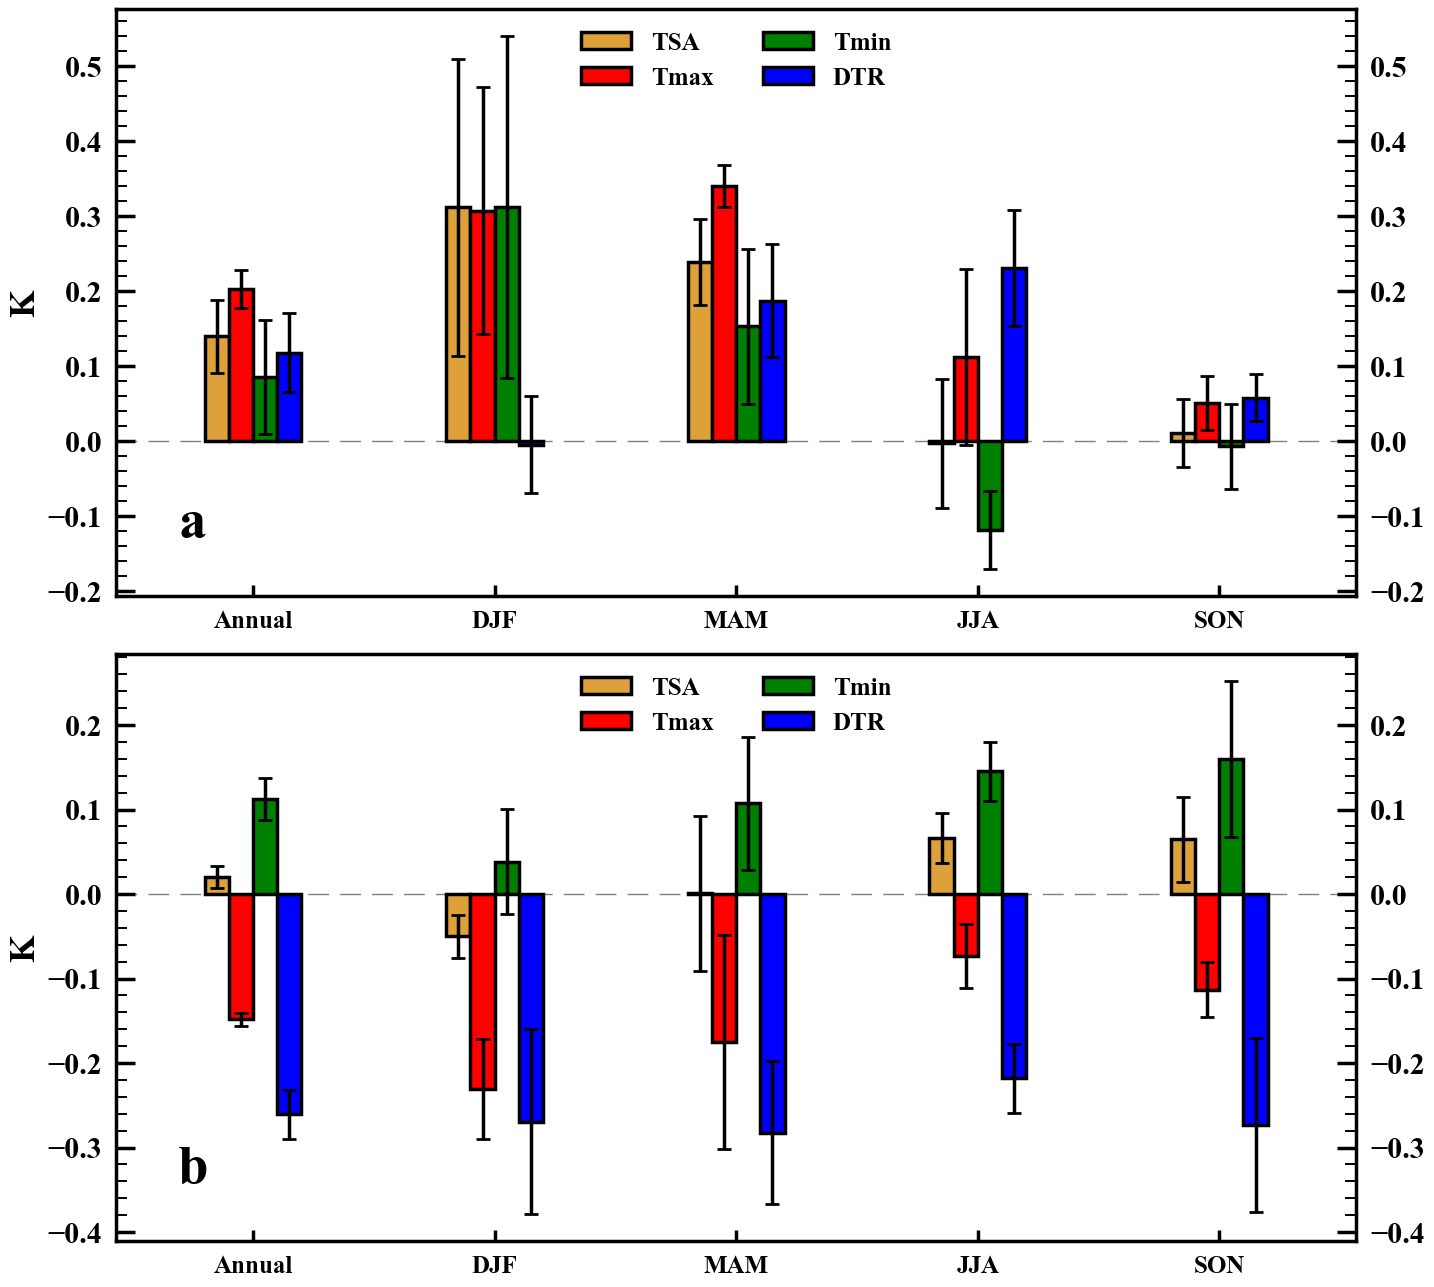

In [7]:
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0, hspace=0.1)
ax = fig.add_subplot(gs[0, 0])
ax.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 0, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 0, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 0, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[0, :, 0, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 0, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax.set_ylabel('K', fontsize=25, weight='bold')
ax.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax.tick_params(axis='x', which='major', length=8)
ax.tick_params(axis='y', labelsize='large')
ax.spines['top'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.set_xlim(-0.5, 30.3)
ax.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'a', fontsize=40, transform=ax.transAxes)



ax2 = fig.add_subplot(gs[1, 0])
ax2.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax2.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax2.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax2.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax2.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax2.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 1, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 1, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 1, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[0, :, 1, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[0, :, 1, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax2.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax2.set_ylabel('K', fontsize=25, weight='bold')
ax2.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax2.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax2.tick_params(axis='x', which='major', length=8)
ax2.tick_params(axis='y', labelsize='large')
ax2.spines['top'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(2.5)
ax2.spines['bottom'].set_linewidth(2.5)
ax2.spines['left'].set_linewidth(2.5)
ax2.set_xlim(-0.5, 30.3)
ax2.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax2.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'b', fontsize=40, transform=ax2.transAxes)
# plt.savefig(f'F:\\hwchen\\fig3-diff-fix-tsa-dtr\\picture\\bar_error\\bar_fix2009-fix1960.png', bbox_inches='tight')

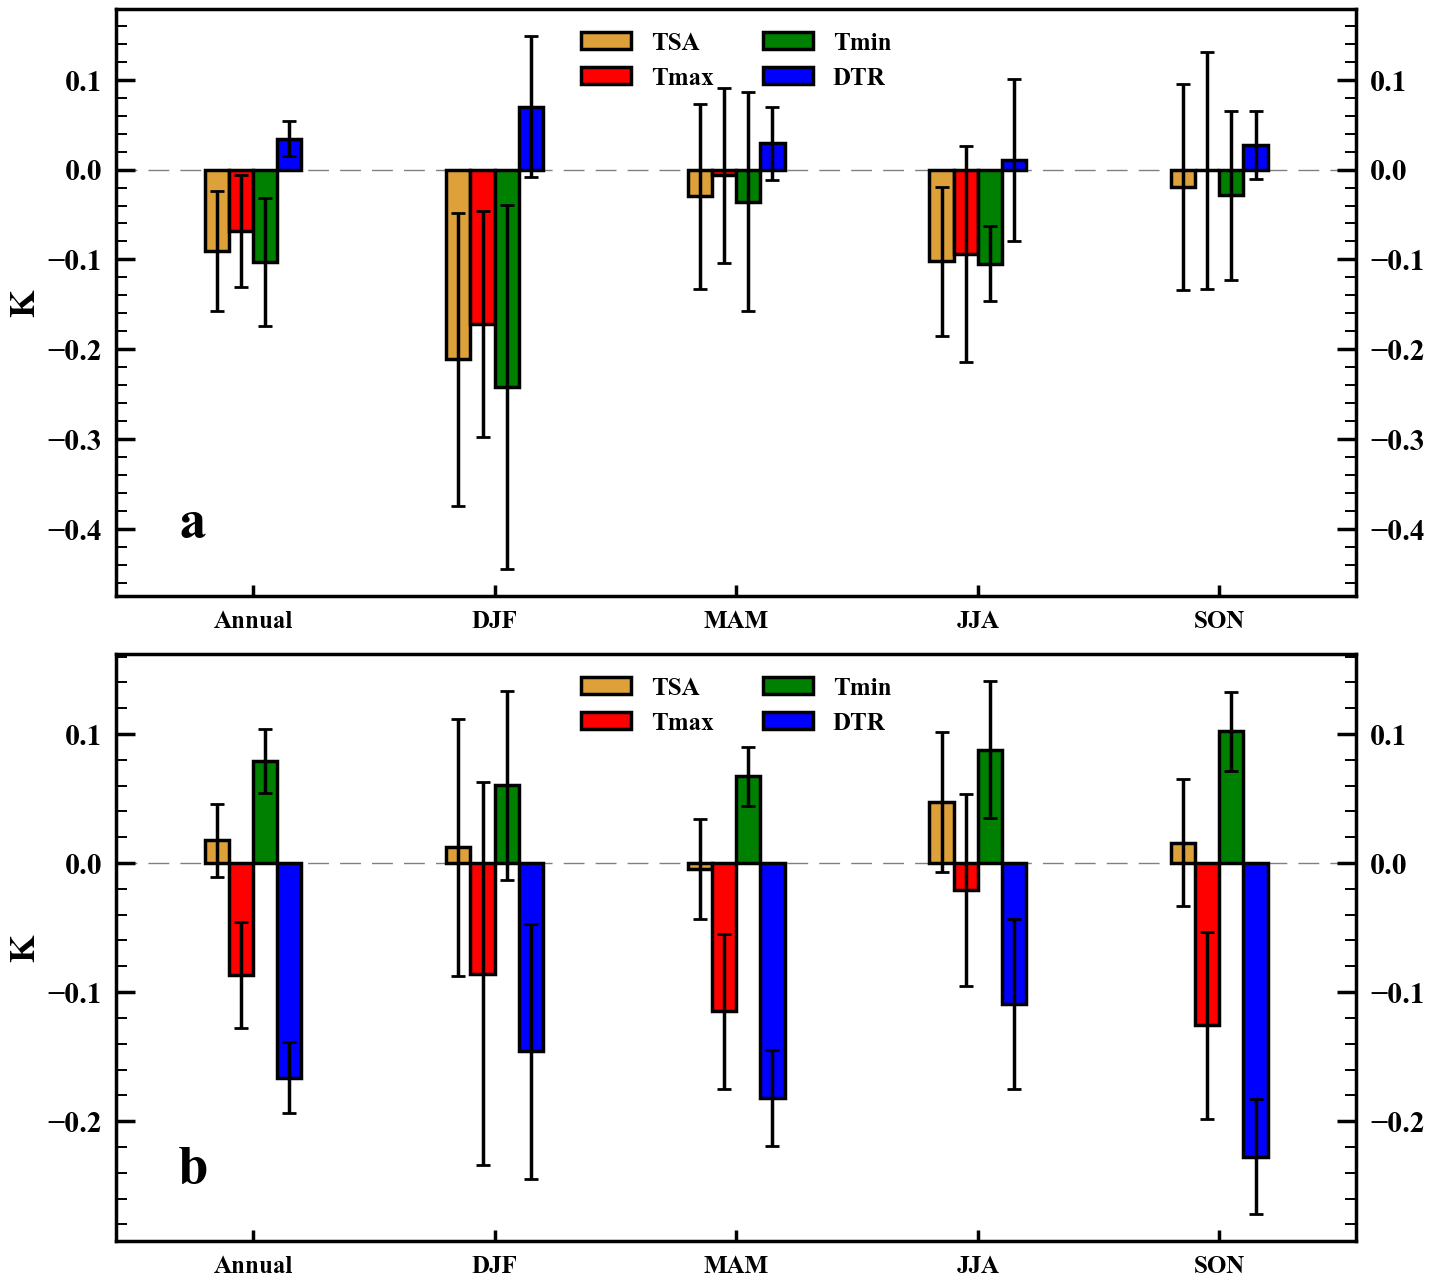

In [8]:
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0, hspace=0.1)
ax = fig.add_subplot(gs[0, 0])
ax.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 0, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 0, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 0, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[1, :, 0, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 0, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax.set_ylabel('K', fontsize=25, weight='bold')
ax.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax.tick_params(axis='x', which='major', length=8)
ax.tick_params(axis='y', labelsize='large')
ax.spines['top'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.set_xlim(-0.5, 30.3)
ax.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'a', fontsize=40, transform=ax.transAxes)



ax2 = fig.add_subplot(gs[1, 0])
ax2.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax2.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax2.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax2.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax2.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax2.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 1, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 1, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 1, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[1, :, 1, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[1, :, 1, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax2.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax2.set_ylabel('K', fontsize=25, weight='bold')
ax2.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax2.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax2.tick_params(axis='x', which='major', length=8)
ax2.tick_params(axis='y', labelsize='large')
ax2.spines['top'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(2.5)
ax2.spines['bottom'].set_linewidth(2.5)
ax2.spines['left'].set_linewidth(2.5)
ax2.set_xlim(-0.5, 30.3)
ax2.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax2.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'b', fontsize=40, transform=ax2.transAxes)
# plt.savefig(f'F:\\hwchen\\fig3-diff-fix-tsa-dtr\\picture\\bar_error\\bar_dyn-fix1960.png', bbox_inches='tight')

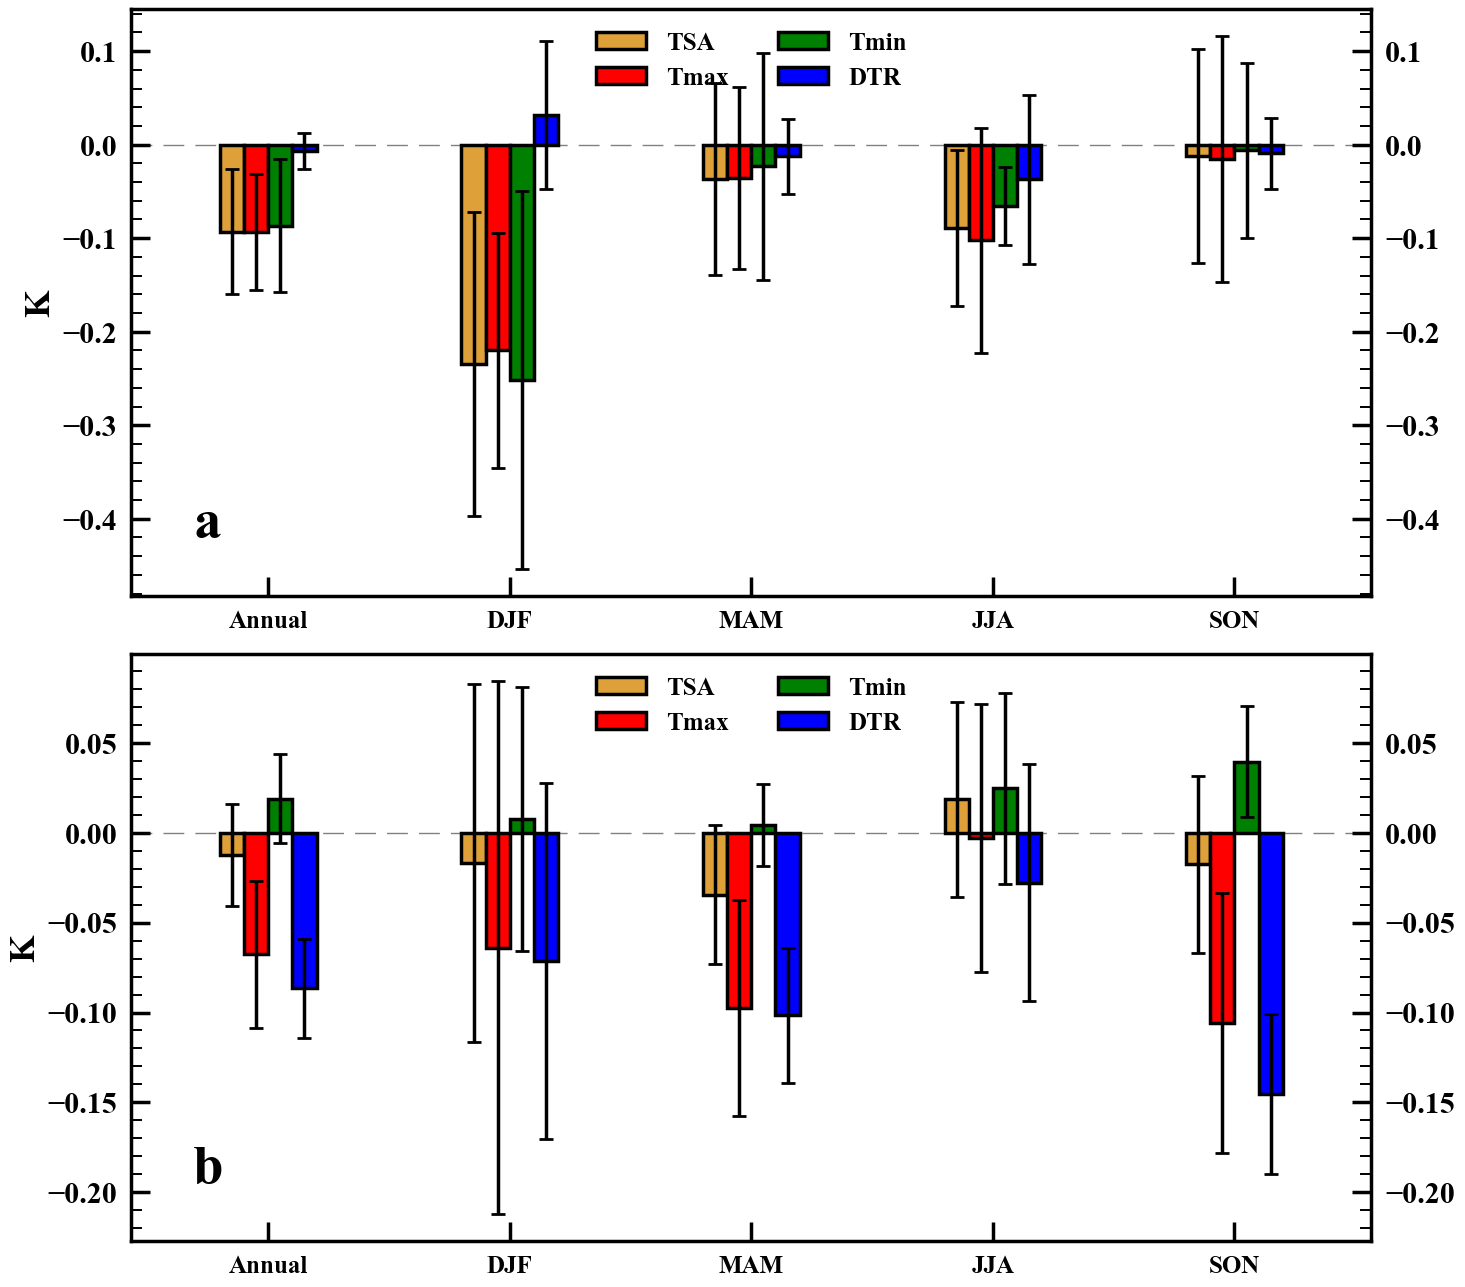

In [9]:
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0, hspace=0.1)
ax = fig.add_subplot(gs[0, 0])
ax.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 0, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 0, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 0, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[2, :, 0, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 0, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax.set_ylabel('K', fontsize=25, weight='bold')
ax.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax.tick_params(axis='y', labelsize='large')
ax.spines['top'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.set_xlim(-0.5, 30.3)
ax.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'a', fontsize=40, transform=ax.transAxes)



ax2 = fig.add_subplot(gs[1, 0])
ax2.axhline(0, linewidth=1, color='grey', linestyle=(0,(15,8)), zorder=1)
bar_tsa = ax2.bar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 0].mean(axis=0), color='#DEA13A', width=0.6, edgecolor='k', linewidth=2.5, label='TSA', zorder=2)
bar_tmax = ax2.bar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 1].mean(axis=0), color='red', width=0.6, edgecolor='k', linewidth=2.5, label='Tmax', zorder=2)
bar_tmin = ax2.bar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 2].mean(axis=0), color='green', width=0.6, edgecolor='k', linewidth=2.5, label='Tmin', zorder=2)
bar_dtr = ax2.bar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 3].mean(axis=0), color='blue', width=0.6, edgecolor='k', linewidth=2.5, label='DTR', zorder=2)
errorbar_tsa = ax2.errorbar(np.arange(2, 30, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 0].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 1, :, 0].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(2.6, 30.6, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 1].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 1, :, 1].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.2, 31.2, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 2].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 1, :, 2].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
errorbar_tsa = ax2.errorbar(np.arange(3.8, 31.8, 6), type3_exp3_region2_season5_data4[2, :, 1, :, 3].mean(axis=0), yerr=type3_exp3_region2_season5_data4[2, :, 1, :, 3].std(axis=0),\
                           fmt='o', ms=0, capsize=5, color='black', elinewidth=2.5, capthick=2, zorder=3)
ax2.legend(loc='upper center', frameon=False, ncol=2, fontsize=18)
ax2.set_ylabel('K', fontsize=25, weight='bold')
ax2.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=False, labelright=True, pad=10)
ax2.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=False)
ax2.tick_params(axis='y', labelsize='large')
ax2.spines['top'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(2.5)
ax2.spines['bottom'].set_linewidth(2.5)
ax2.spines['left'].set_linewidth(2.5)
ax2.set_xlim(-0.5, 30.3)
ax2.set_xticks([2.9, 8.9, 14.9, 20.9, 26.9])
ax2.set_xticklabels(['Annual', 'DJF', 'MAM', 'JJA', 'SON'])
plt.text(0.05, 0.1, f'b', fontsize=40, transform=ax2.transAxes)
# plt.savefig(f'F:\\hwchen\\fig3-diff-fix-tsa-dtr\\picture\\bar_error\\bar_fc5-ic45.png', bbox_inches='tight')